# Telecom Customer Churn
## ADS 502 Final Project
Connie Chow, Vannesa Salazar, Christine Vu

## Data Importing and Pre-processing

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from collections import defaultdict
from scipy import stats
from sklearn.cluster import KMeans
from pandas.api.types import CategoricalDtype
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import statsmodels.tools.tools as stattools
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree


df = pd.read_csv('https://raw.githubusercontent.com/USD-502-FinalProject/502-Summer2022-FinalProject/main/telecom_customer_churn.csv', sep=',', na_values='?')
df_zip = pd.read_csv('https://raw.githubusercontent.com/USD-502-FinalProject/502-Summer2022-FinalProject/main/telecom_zipcode_population.csv', sep=',')


# DATA QUALITY ##################################################################
#print(df.head(5))
#print(df.columns)


# Set flags here for output #####################################################
z_correlation_matrix = True

In [2]:
############################################################################
# Assign binary values for 'Customer Status' target variable
# Loop through each row of dataframe, assigning value for 'Customer Status'
# as either 0 or 1
for i, row in df.iterrows():

    val = 0  # default Stayed

    # Joined or Stayed
    if row['Customer Status'] == 'Stayed' or row['Customer Status'] == 'Joined':
        val = 0
    else:  # Churned
        val = 1

    df.at[i,'Customer Status'] = val


# Convert 'Customer Status' column into int/numeric
df['Customer Status'] = pd.to_numeric(df['Customer Status'])

In [3]:
#Find the shape of the data, how instances and attributes (VS)
print('Number of instances = %d' % (df.shape[0]))
print('Number of attributes = %d' % (df.shape[1]))
df.head()

Number of instances = 7043
Number of attributes = 38


,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,0,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,0,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability


In [4]:
###Find missing/NAN values in the dataframe and how many in each 
# column (VS)
for col in df.columns:
    print('\t%s: %d' % (col,df[col].isna().sum()))

	Customer ID: 0
	Gender: 0
	Age: 0
	Married: 0
	Number of Dependents: 0
	City: 0
	Zip Code: 0
	Latitude: 0
	Longitude: 0
	Number of Referrals: 0
	Tenure in Months: 0
	Offer: 0
	Phone Service: 0
	Avg Monthly Long Distance Charges: 682
	Multiple Lines: 682
	Internet Service: 0
	Internet Type: 1526
	Avg Monthly GB Download: 1526
	Online Security: 1526
	Online Backup: 1526
	Device Protection Plan: 1526
	Premium Tech Support: 1526
	Streaming TV: 1526
	Streaming Movies: 1526
	Streaming Music: 1526
	Unlimited Data: 1526
	Contract: 0
	Paperless Billing: 0
	Payment Method: 0
	Monthly Charge: 0
	Total Charges: 0
	Total Refunds: 0
	Total Extra Data Charges: 0
	Total Long Distance Charges: 0
	Total Revenue: 0
	Customer Status: 0
	Churn Category: 5174
	Churn Reason: 5174


In [5]:
print('Number of rows in original data = %d' % (df.shape[0]))

Number of rows in original data = 7043


In [6]:
###Imput values for the NAN Variables (VS)
imputer = SimpleImputer(strategy='constant',
                       fill_value='missing')
imputer = imputer.fit(df[['Churn Category']])
df[['Churn Category']] = imputer.transform(df[['Churn Category']])
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,NaN
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,NaN
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,NaN


In [7]:
###Imput variables for NAN values (VS)
imputer2 = SimpleImputer(strategy='constant',
                       fill_value='missing')
imputer2 = imputer.fit(df[['Churn Reason']])
df[['Churn Reason']] = imputer.transform(df[['Churn Reason']])
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,missing
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,missing
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,missing


In [8]:
df['Avg Monthly Long Distance Charges']

0       42.39
1       10.69
2       33.65
3       27.82
4        7.38
        ...  
7038    46.68
7039    16.20
7040    18.62
7041     2.12
7042      NaN
Name: Avg Monthly Long Distance Charges, Length: 7043, dtype: float64

In [9]:
###Imput missing values with mean of column (VS)
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].fillna(df['Avg Monthly Long Distance Charges'].mean())
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,missing
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,missing
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,missing


In [10]:
### Impute missing values with mean of column (VS)
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].fillna(df['Avg Monthly GB Download'].mean())
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,missing
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,missing
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,missing


In [11]:
df['Multiple Lines']

0        No
1       Yes
2        No
3        No
4        No
       ... 
7038     No
7039    Yes
7040     No
7041     No
7042    NaN
Name: Multiple Lines, Length: 7043, dtype: object

In [12]:
###Imput values of missing values in multiple lines (VS)
imputermult = SimpleImputer(strategy='constant',
                       fill_value='missing')
imputermult = imputer.fit(df[['Multiple Lines']])
df[['Multiple Lines']] = imputer.transform(df[['Multiple Lines']])
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,missing
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,missing
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,missing


In [13]:
#Impute missing values in the below columns. (VS)
imputerlast = SimpleImputer(strategy='constant',
                       missing_values=np.nan, fill_value=0)
imputerlast = imputer.fit(df[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Music', 'Streaming Movies', 'Unlimited Data']])
df[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Music', 'Streaming Movies', 'Unlimited Data']] = imputer.transform(df[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Music', 'Streaming Movies', 'Unlimited Data']])
df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,20,No,0,La Mesa,91941,32.759327,-116.997260,0,...,Credit Card,55.15,742.90,0.00,0,606.84,1349.74,0,missing,missing
7039,9992-RRAMN,Male,40,Yes,0,Riverbank,95367,37.734971,-120.954271,1,...,Bank Withdrawal,85.10,1873.70,0.00,0,356.40,2230.10,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,22,No,0,Elk,95432,39.108252,-123.645121,0,...,Credit Card,50.30,92.75,0.00,0,37.24,129.99,0,missing,missing
7041,9993-LHIEB,Male,21,Yes,0,Solana Beach,92075,33.001813,-117.263628,5,...,Credit Card,67.85,4627.65,0.00,0,142.04,4769.69,0,missing,missing


In [14]:
print('Number of rows in after missing values = %d' % (df.shape[0]))

Number of rows in after missing values = 7043


In [15]:
###VS
print(df.isnull().sum())

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

In [16]:
print('Number of rows in original data = %d' % (df.shape[0]))

Number of rows in original data = 7043


In [17]:
###Look at types of data in DF (VS)
df.dtypes

Customer ID                           object
Gender                                object
Age                                    int64
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Number of Referrals                    int64
Tenure in Months                       int64
Offer                                 object
Phone Service                         object
Avg Monthly Long Distance Charges    float64
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Avg Monthly GB Download              float64
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming 

In [18]:
###Drop all columns from new dataframe to 
# visual all outliers in remaining columns. (VS)
df2 = df.drop(['Customer ID', 
                     'Number of Dependents', 'Gender', 'Married', 'City',
               'Zip Code', 'Latitude',
               'Longitude', 'Offer', 'Phone Service',
               'Internet Type', 'Multiple Lines','Internet Service', 
                     'Online Security', 'Online Backup',
                     'Device Protection Plan', 'Premium Tech Support',
                     'Streaming TV', 'Streaming Music', 'Streaming Movies',
                     'Unlimited Data', 'Contract', 'Paperless Billing',
                     'Payment Method', 'Customer Status', 'Churn Category',
                     'Churn Reason'],axis=1)

In [19]:
###Drop columns from df2 in new df1,so that 
# they can be merged with outliers removed.(VS)
df1 = df.drop(['Age', 'Number of Referrals', 'Tenure in Months',
               'Avg Monthly Long Distance Charges',
              'Avg Monthly GB Download', 'Monthly Charge',
               'Total Charges', 'Total Refunds',
              'Total Extra Data Charges', 'Total Long Distance Charges',
               'Total Revenue'],axis=1)

In [20]:
df1

,Customer ID,Gender,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Offer,Phone Service,...,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Paperless Billing,Payment Method,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,Yes,0,Frazier Park,93225,34.827662,-118.999073,None,Yes,...,Yes,No,No,Yes,One Year,Yes,Credit Card,0,missing,missing
1,0003-MKNFE,Male,No,0,Glendale,91206,34.162515,-118.203869,None,Yes,...,No,Yes,Yes,No,Month-to-Month,No,Credit Card,0,missing,missing
2,0004-TLHLJ,Male,No,0,Costa Mesa,92627,33.645672,-117.922613,Offer E,Yes,...,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,Yes,0,Martinez,94553,38.014457,-122.115432,Offer D,Yes,...,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,Yes,0,Camarillo,93010,34.227846,-119.079903,None,Yes,...,Yes,No,No,Yes,Month-to-Month,Yes,Credit Card,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,9987-LUTYD,Female,No,0,La Mesa,91941,32.759327,-116.997260,Offer D,Yes,...,No,No,Yes,Yes,One Year,No,Credit Card,0,missing,missing
7039,9992-RRAMN,Male,Yes,0,Riverbank,95367,37.734971,-120.954271,Offer D,Yes,...,No,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,1,Dissatisfaction,Product dissatisfaction
7040,9992-UJOEL,Male,No,0,Elk,95432,39.108252,-123.645121,Offer E,Yes,...,No,No,No,Yes,Month-to-Month,Yes,Credit Card,0,missing,missing
7041,9993-LHIEB,Male,Yes,0,Solana Beach,92075,33.001813,-117.263628,Offer A,Yes,...,No,Yes,Yes,Yes,Two Year,No,Credit Card,0,missing,missing


In [21]:
###Set figure size for seaborn boxplot
sns.set(rc={'figure.figsize':(11,8)})

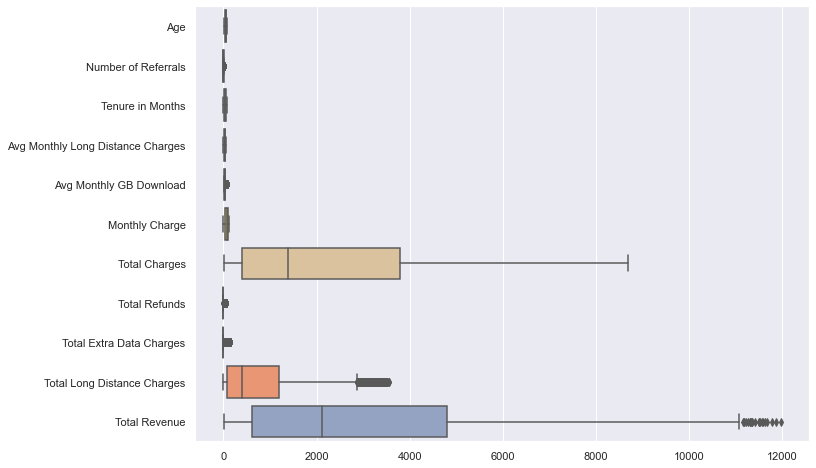

In [22]:
### plot all attributes in DF that have outliers to visualize them(VS) 
bp = sns.boxplot(data=df2, orient="h", palette="Set2")

<AxesSubplot:xlabel='Age'>

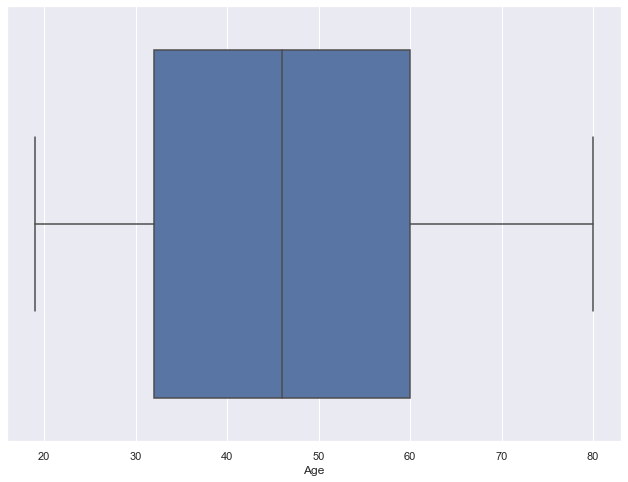

In [23]:
###Use SNS boxplots to further observes with attributes have outliers
#.(VS) (all boxes created by VS)
sns.boxplot(x=df['Age'])

<AxesSubplot:xlabel='Number of Referrals'>

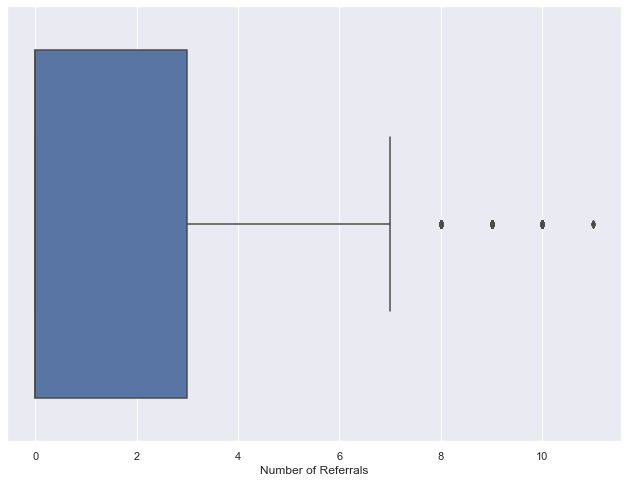

In [24]:
sns.boxplot(x=df['Number of Referrals'])

<AxesSubplot:xlabel='Tenure in Months'>

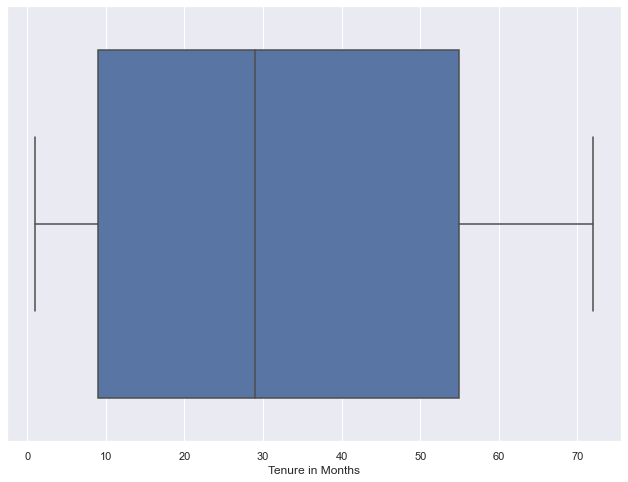

In [25]:
sns.boxplot(x=df['Tenure in Months'])

<AxesSubplot:xlabel='Avg Monthly Long Distance Charges'>

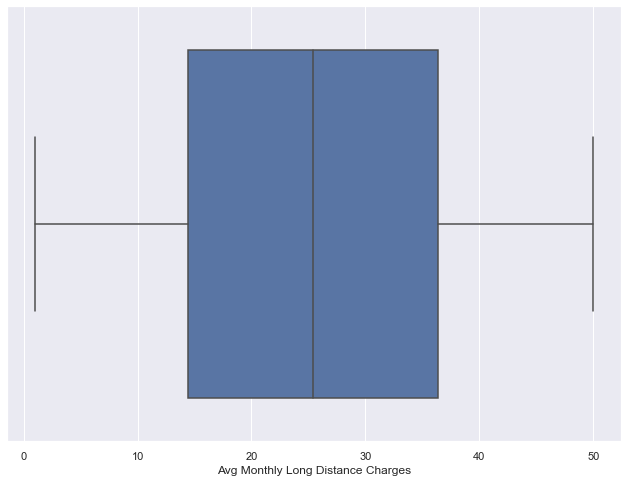

In [26]:
sns.boxplot(x=df['Avg Monthly Long Distance Charges'])

<AxesSubplot:xlabel='Avg Monthly GB Download'>

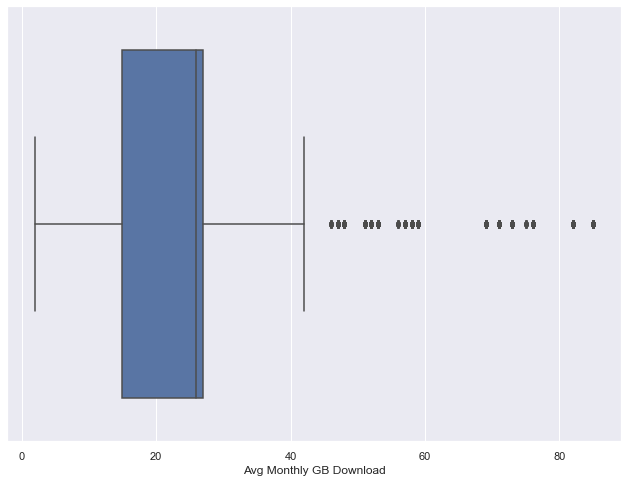

In [27]:
sns.boxplot(x=df['Avg Monthly GB Download'])

<AxesSubplot:xlabel='Monthly Charge'>

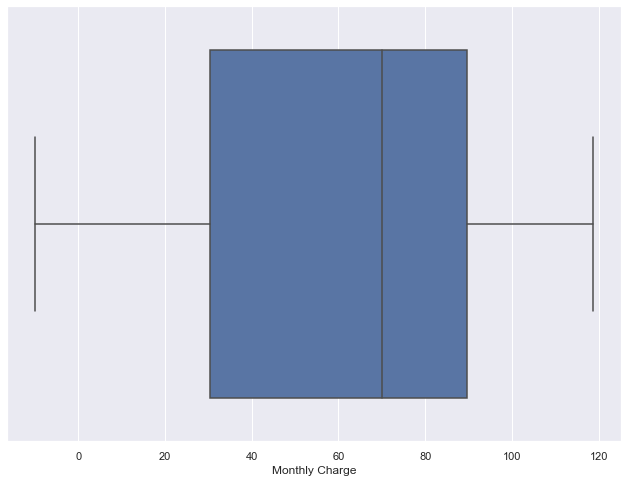

In [28]:
sns.boxplot(x=df['Monthly Charge'])

<AxesSubplot:xlabel='Total Charges'>

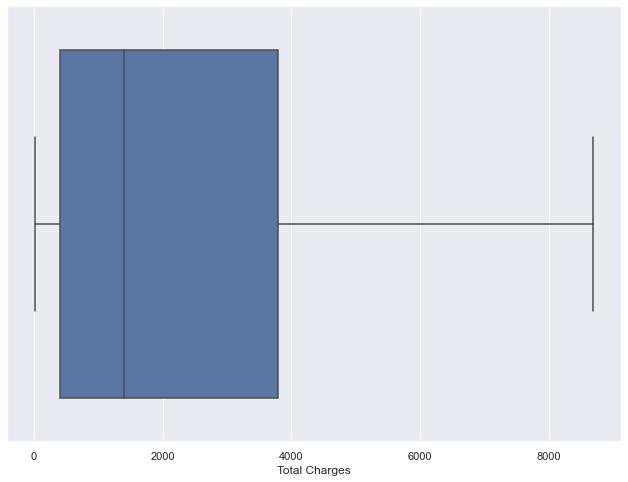

In [29]:
sns.boxplot(x=df['Total Charges'])

<AxesSubplot:xlabel='Total Refunds'>

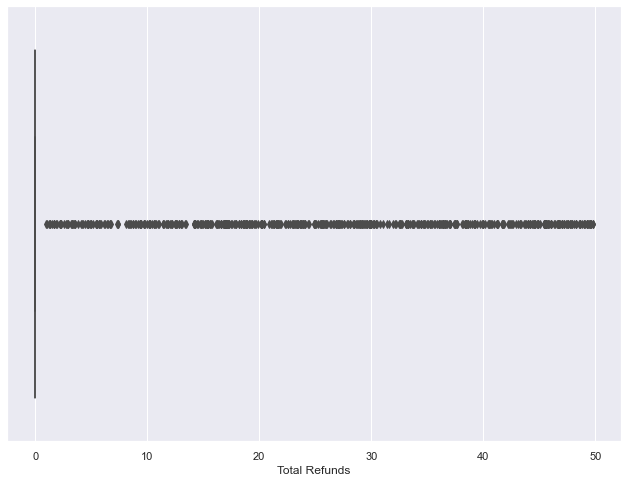

In [30]:
sns.boxplot(x=df['Total Refunds'])

<AxesSubplot:xlabel='Total Extra Data Charges'>

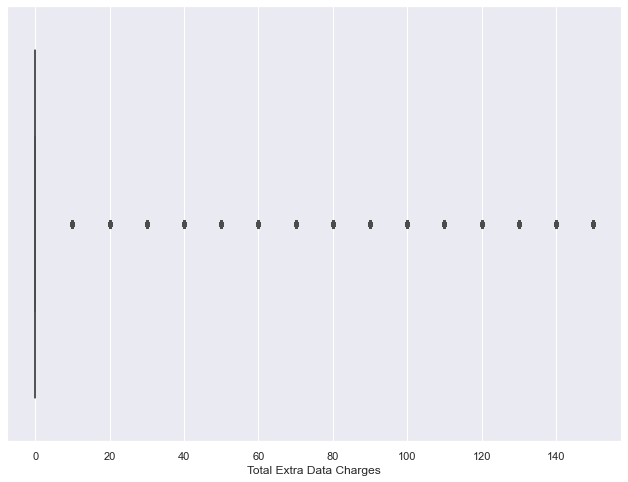

In [31]:
sns.boxplot(x=df['Total Extra Data Charges'])

<AxesSubplot:xlabel='Total Long Distance Charges'>

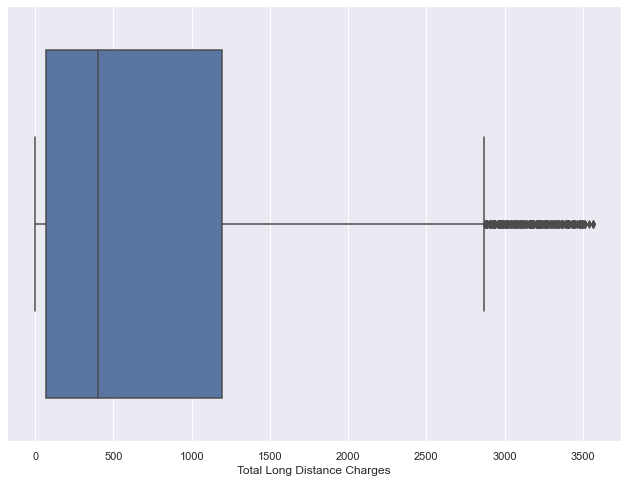

In [32]:
sns.boxplot(x=df['Total Long Distance Charges'])

<AxesSubplot:xlabel='Total Revenue'>

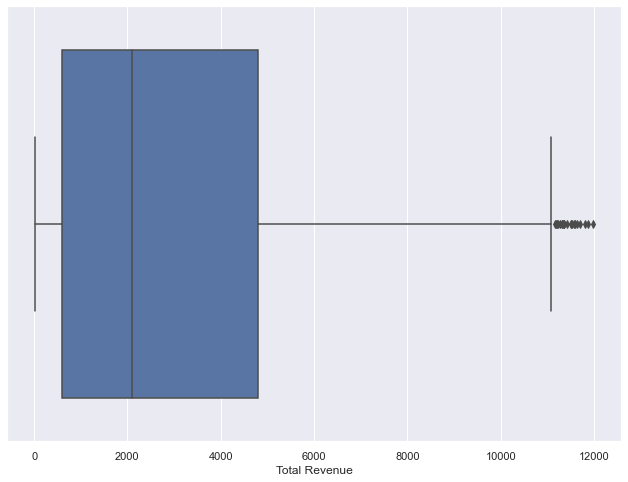

In [33]:
sns.boxplot(x=df['Total Revenue'])

In [34]:
############################################################
###standardize the DF with zscores so that outliers can be removed,
#as above we have observed a significant
###amount of outliers. 
Z = (df2-df2.mean())/df2.std()

###############################################################

In [35]:
Z

,Age,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,-0.567733,0.016038,-0.952926,1.257443e+00,-0.587827,0.064217,-0.744447,-0.248295,-0.273281,-0.434164,-0.718821
1,-0.030431,-0.650362,-0.952926,-1.091535e+00,-0.933948,-2.166213,-0.766907,4.601998,0.125046,-0.771135,-0.846047
2,0.208370,-0.650362,-1.156658,6.098067e-01,0.219789,0.330202,-0.882320,-0.248295,-0.273281,-0.725792,-0.914046
3,1.879977,-0.317162,-0.789940,1.778023e-01,-1.280070,1.102521,-0.460031,-0.248295,-0.273281,-0.457609,-0.500791
4,1.700876,0.349238,-1.197404,-1.336807e+00,-0.876262,0.650666,-0.888255,-0.248295,-0.273281,-0.858620,-0.957991
...,...,...,...,...,...,...,...,...,...,...,...
7038,-1.582637,-0.650362,-0.789940,1.575333e+00,1.892709,-0.270668,-0.678434,-0.248295,-0.273281,-0.168024,-0.587965
7039,-0.388632,-0.317162,-0.423223,-6.832426e-01,-0.530140,0.689122,-0.179454,-0.248295,-0.273281,-0.463822,-0.280706
7040,-1.463237,-0.650362,-1.238151,-5.039200e-01,1.431214,-0.426093,-0.965321,-0.248295,-0.273281,-0.840785,-1.013676
7041,-1.522937,1.015638,1.410364,-1.726574e+00,1.835022,0.136321,1.035764,-0.248295,-0.273281,-0.717005,0.605650


In [36]:
print('Number of rows before discarding outliers = %d' % (Z.shape[0]))

Z2 = Z.loc[((Z > -3).sum(axis=1)==11) & ((Z <= 3).sum(axis=1)==11),:]
print('Number of rows after discarding missing values = %d' % (Z2.shape[0]))

Number of rows before discarding outliers = 7043
Number of rows after discarding missing values = 6390


In [37]:
dups = df2.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of duplicate rows = 0


In [38]:
# FEATURE SCALING - STANDARDIZING THE COLUMN VALUES - NUMERIC ONLY ############
# NOT NEEDED for our binary classifier models but we keep it here commented out
# in case the need arises
# Logistic Regression, Decision Tree, Random Forest, Naive Bayes, SVM
# are not sensitive to the magnitude of variables, so feature scaling not
# required
# Only required if the logistic regression is regularized in which case
# the input needs to be normalized
#df_numeric = df._get_numeric_data()
#Z = (data2-data2.mean())/data2.std()

In [39]:
################################################################################################
# NORMALIZE THE NUMERIC COLUMNS
# Only necessary for models like KNN, not necessary for logistic regression
################################################################################################
#scaler = MinMaxScaler()

# normalize all the numeric columns in df
#df_numeric_columns = df._get_numeric_data()

# remove Zip Code, Longitude, Latitude, normalizing these makes no sense
#df_numeric_columns = df_numeric_columns.drop(['Zip Code', 'Longitude', 'Latitude', 'Customer Status'], axis=1)

# Perform the transformation on the data so that it is scaled to range 0-1
#df_scaled = scaler.fit_transform(df_numeric_columns)

# create a new dataframe containing the normalized values and corresponding column names
#norm = pd.DataFrame(df_scaled, columns = df._get_numeric_data().columns)
#norm = pd.DataFrame(df_scaled, columns = df_numeric_columns.columns)

#norm.head(2)

# Takes df_master dataframe and replaces the normalized columns from norm_df
#def replace_norms(df_master, df_norm):
    #cols = df_norm.columns
    #for col in cols:
       # df_master[col] = df_norm[col]

#replace_norms(df, norm)
#df.head(2)

In [40]:
################################################################################################
# ONE HOT ENCODING
# One method used to handle the categorical columns and expands them out into binary form
# Disadvantage: Creates a lot of additional columns
# Use for non-ordinal categorical values and when there are not so many categorical values per column
# Typically use PCA reduction afterwards because it produces too many columns
# https://www.analyticsvidhya.com/blog/2020/03/one-hot-encoding-vs-label-encoding-using-scikit-learn/
# https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor
# https://www.ritchieng.com/machinelearning-one-hot-encoding/
# https://stats.stackexchange.com/questions/48360/is-standardization-needed-before-fitting-logistic-regression#:~:text=You%20don't%20need%20to,helps%20interpretability%2C%20and%20rarely%20hurts.
#
# Issues to check on:
# Does zip code or city have any correlation to Churn ?
# Correlation matrix shows that City has very little correlation with Churn,
# so for now we don't hotencode.  Zip Code with city-data.com may provide
# additional insight into the demographic data relating to a zipcode but
# that is extra if we have time.
################################################################################################

# Select all categorical value columns, they will be of type object
df_cat_cols = pd.DataFrame(df.dtypes[df.dtypes == 'object'])

# fill any missing values with "other" and then drop these columns after the hot encoding
df_cat_cols = df_cat_cols.fillna("other", axis="index")

cat_cols = np.array(df_cat_cols.index)

# We do not need to onehotencode Customer Status because this is the target
# variable.  Customer ID is irrelevant.
# Not sure what to do about City right now, it increases the dimensionality
# by too much.  We can decide what do with it later after I get the model working.
#cat_cols = np.array(pd.DataFrame(df.dtypes[df.dtypes == 'object']).index)
#cat_cols = np.delete(cat_cols, 20) # remove the target variable 'Customer Status'
cat_cols = np.delete(cat_cols, 0)  # remove Customer ID
cat_cols = np.delete(cat_cols, 2)  # remove City - no correlation from matrix
#cat_cols = df.select_dtypes(include=[object])


# Drop the first feature in the category
#ohe = OneHotEncoder(drop = 'first').fit(df[cat_cols])
ohe = OneHotEncoder().fit(df[cat_cols])
# why don't you just get_dummies()?

# perform the one hot encoding on the categorical columns
# assign it to an array type
# We end up with 8200 columns....too big!
ohe_array = ohe.fit_transform(df[cat_cols]).toarray()

# Take the array of one hot encoded columns and create a dataframe out of it
ohe_df = pd.DataFrame(ohe_array, index = df.index, columns = ohe.get_feature_names(cat_cols))

# Drop the categorical columns from the original dataframe
df_drop_col = df.drop(columns = cat_cols)

# Merge the one hot encoded columns and the dataframe containing the dropped columns
df_ohed = pd.concat([df_drop_col, ohe_df], axis = 1)
df_ohed.columns
print(df_ohed.head(2))


  Customer ID  Age  Number of Dependents          City  Zip Code   Latitude  \
0  0002-ORFBO   37                     0  Frazier Park     93225  34.827662   
1  0003-MKNFE   46                     0      Glendale     91206  34.162515   

    Longitude  Number of Referrals  Tenure in Months  \
0 -118.999073                    2                 9   
1 -118.203869                    0                 9   

   Avg Monthly Long Distance Charges  ...  \
0                              42.39  ...   
1                              10.69  ...   

   Churn Reason_Limited range of services  Churn Reason_Long distance charges  \
0                                     0.0                                 0.0   
1                                     0.0                                 0.0   

   Churn Reason_Moved  Churn Reason_Network reliability  \
0                 0.0                               0.0   
1                 0.0                               0.0   

   Churn Reason_Poor expertise of o

/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [41]:
###Combine both DF back so that all the columns are back together
###outliers are removed (VS)
df_combine = pd.concat([df1, df2], axis = 1)

df_combine.head()

,Customer ID,Gender,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Offer,Phone Service,...,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
0,0002-ORFBO,Female,Yes,0,Frazier Park,93225,34.827662,-118.999073,None,Yes,...,2,9,42.39,16.0,65.6,593.30,0.00,0,381.51,974.81
1,0003-MKNFE,Male,No,0,Glendale,91206,34.162515,-118.203869,None,Yes,...,0,9,10.69,10.0,-4.0,542.40,38.33,10,96.21,610.28
2,0004-TLHLJ,Male,No,0,Costa Mesa,92627,33.645672,-117.922613,Offer E,Yes,...,0,4,33.65,30.0,73.9,280.85,0.00,0,134.60,415.45
3,0011-IGKFF,Male,Yes,0,Martinez,94553,38.014457,-122.115432,Offer D,Yes,...,1,13,27.82,4.0,98.0,1237.85,0.00,0,361.66,1599.51
4,0013-EXCHZ,Female,Yes,0,Camarillo,93010,34.227846,-119.079903,None,Yes,...,3,3,7.38,11.0,83.9,267.40,0.00,0,22.14,289.54


In [42]:
# Created by CV
# Determine if 'Customer Status' column is balanced
# '0' = No/Stayed and '1' = Yes/Churned
df['Customer Status'].value_counts()

0    5174
1    1869
Name: Customer Status, dtype: int64

In [43]:
# Created by CV
# Rebalance 1/Yes(Churned) in 'Customer Status' column
# Rebalance 30%: (0.3*7043-1869) / 0.7 = 348

to_resample = df.loc[df['Customer Status'] == 1]
our_resample = to_resample.sample(n = 348, replace = True)
df = pd.concat([df, our_resample])

# Determine if 'Customer Status' column is balanced
df['Customer Status'].value_counts()

0    5174
1    2217
Name: Customer Status, dtype: int64

In [44]:
# Created by CV
# Count of missing values per column in churn data frame
print(df.isnull().sum(), "\n")

# Count of missing values per column in zipcode data frame
print(df_zip.isnull().sum())

Customer ID                          0
Gender                               0
Age                                  0
Married                              0
Number of Dependents                 0
City                                 0
Zip Code                             0
Latitude                             0
Longitude                            0
Number of Referrals                  0
Tenure in Months                     0
Offer                                0
Phone Service                        0
Avg Monthly Long Distance Charges    0
Multiple Lines                       0
Internet Service                     0
Internet Type                        0
Avg Monthly GB Download              0
Online Security                      0
Online Backup                        0
Device Protection Plan               0
Premium Tech Support                 0
Streaming TV                         0
Streaming Movies                     0
Streaming Music                      0
Unlimited Data           

In [45]:
# Created by CV
# Key statistics of studied variables
df.describe()

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status
count,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000,7391.000000
mean,46.701935,0.452036,93483.931403,36.190616,-119.751935,1.883372,31.712082,25.461237,26.082592,64.126106,2247.851758,1.941534,7.015289,736.096174,2989.021686,0.299959
std,16.849201,0.950660,1855.973532,2.473341,2.156280,2.955957,24.536067,13.509548,17.310988,31.076213,2258.378782,7.881435,25.347269,841.601022,2859.596811,0.458271
min,19.000000,0.000000,90001.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000,0.000000
25%,32.000000,0.000000,92103.500000,33.987945,-121.777959,0.000000,8.000000,14.490000,15.000000,34.650000,379.900000,0.000000,0.000000,65.660000,568.020000,0.000000
50%,46.000000,0.000000,93517.000000,36.186867,-119.593757,0.000000,27.000000,25.420517,26.000000,70.350000,1360.250000,0.000000,0.000000,383.000000,2036.550000,0.000000
75%,60.000000,0.000000,95329.500000,38.161321,-117.961179,3.000000,55.000000,36.475000,27.000000,89.900000,3722.775000,0.000000,0.000000,1171.175000,4726.150000,1.000000
max,80.000000,9.000000,96150.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000,1.000000


In [46]:
df_combine.dtypes

Customer ID                           object
Gender                                object
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Offer                                 object
Phone Service                         object
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming TV                          object
Streaming Movies                      object
Streaming Music                       object
Unlimited Data                        object
Contract                              object
Paperless 

In [47]:
# Created by CV

# Bin 'Age' column categories:
# Ages 0 to 3: Toddler
# Ages 4 to 17: Child
# Ages 18 to 25: Young Adult
# Ages 26 to 64: Adult
# Ages 65 to 99: Elder

new_df = df.copy()
new_df['Age'] = pd.cut(new_df['Age'], bins=[0,3,17,25,64,99],
                       labels=['Toddler', 'Child', 'Young Adult', 'Adult', 'Elder'])

new_df

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,Adult,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.60,593.30,0.00,0,381.51,974.81,0,missing,missing
1,0003-MKNFE,Male,Adult,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.00,542.40,38.33,10,96.21,610.28,0,missing,missing
2,0004-TLHLJ,Male,Adult,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.90,280.85,0.00,0,134.60,415.45,1,Competitor,Competitor had better devices
3,0011-IGKFF,Male,Elder,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.00,1237.85,0.00,0,361.66,1599.51,1,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,Elder,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.90,267.40,0.00,0,22.14,289.54,1,Dissatisfaction,Network reliability
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,5244-IRFIH,Male,Elder,Yes,0,San Diego,92129,32.961064,-117.134917,1,...,Bank Withdrawal,94.50,3105.55,0.00,0,916.74,4022.29,1,Dissatisfaction,Poor expertise of online support
3764,5299-SJCZT,Male,Adult,No,0,Ladera Ranch,92694,33.569186,-117.640055,0,...,Bank Withdrawal,101.55,298.35,0.00,0,65.58,363.93,1,Dissatisfaction,Network reliability
1658,2408-TZMJL,Male,Adult,Yes,0,Gualala,95445,38.848082,-123.506080,1,...,Bank Withdrawal,110.15,6448.05,0.00,0,1339.89,7787.94,1,Dissatisfaction,Network reliability
6426,9101-BWFSS,Female,Adult,Yes,0,Tollhouse,93667,36.993666,-119.348267,1,...,Bank Withdrawal,108.55,5610.70,0.00,0,1471.50,7082.20,1,Other,Moved


## Exploratory Data Analysis: Multivariate Analysis
1. Relationship between two categorical variables
2. Relationship between two continuous variables
3. Relationship between one categorical and one continuous variable

In [48]:
#######################################################################
###Multivariate Analysis 
###relationship between two categorical variables (VS)

#Churn category is categorical data, and Phone service is binary data 
#with the answer being two mutually exclusive categorical 'Yes' or 'No'
crosstab01 = pd.crosstab(df_combine['Churn Category'], df_combine['Phone Service'])
crosstab01 = crosstab01.sort_values('Yes', ascending=False)
crosstab01


#######################################################################b

Phone Service,No,Yes
Churn Category,,
missing,512,4662
Competitor,75,766
Attitude,26,288
Dissatisfaction,39,282
Price,14,197
Other,16,166


<AxesSubplot:xlabel='Churn Category'>

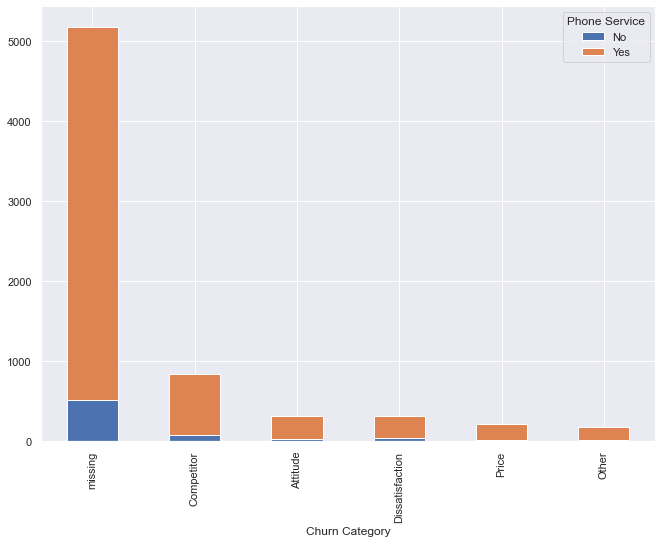

In [49]:
###Bar graph created by VS
crosstab01.plot(kind='bar', stacked = True)

In [50]:
crosstab_norm = crosstab01.div(crosstab01.sum(axis=1), axis = 0)

<AxesSubplot:xlabel='Churn Category'>

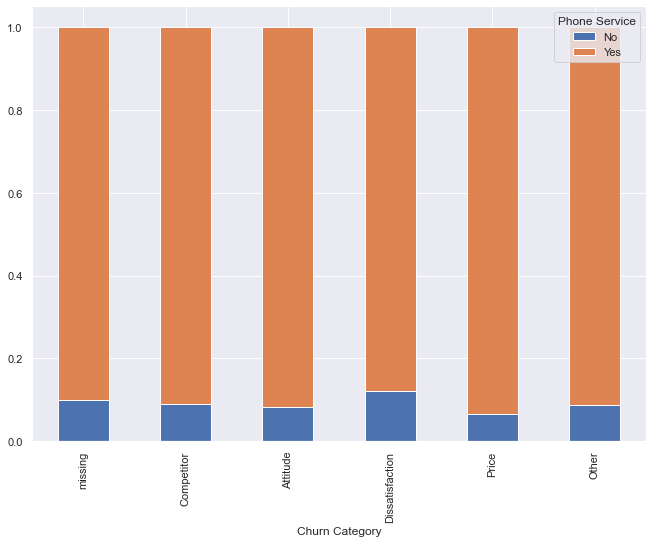

In [51]:
crosstab_norm.plot(kind='bar', stacked = True)

In [52]:
#####################################################
####ANALYSIS (VS)
# based on the review of churn category (whether or not the customer stayed with the telecom company
# and if they had phone service result in the following)
# All of the customers who churned were more likely to have phone service than not. 
# but more important is that majority of the persons who stayed with the company have phone services.
#####################################################

In [53]:
#####################################################
# Relationship between a continous variable and a categorical variable
#####################################################

<AxesSubplot:title={'center':'Histogram of Avg Monthly GB Download'}, ylabel='Frequency'>

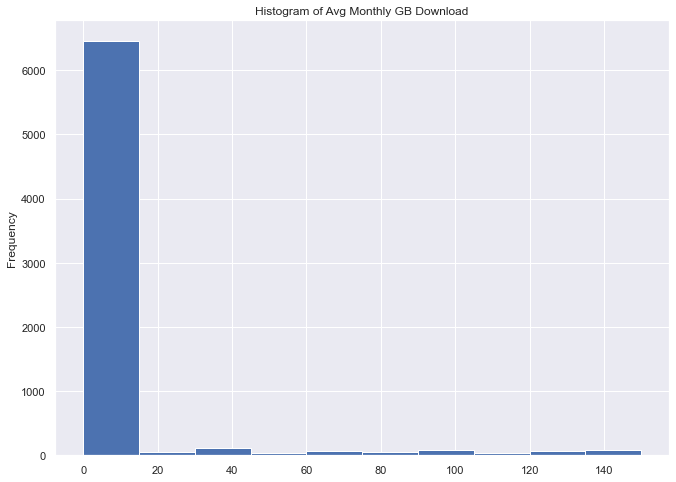

In [54]:
###Created by VS
df_combine['Total Extra Data Charges'].plot(kind = 'hist',
                                          title =
                                    'Histogram of Avg Monthly GB Download')

In [55]:
####Created by VS
df_combine['Totaldata_Binned'] = pd.cut(x = 
                                        df_combine['Total Extra Data Charges'],
                                  bins = [0, 25, 60, 100],
                                  labels=
                                        ["Under 25", "25 to 60", "Over 60"])

<AxesSubplot:title={'center':'Bar Graph of Total Extra Data Charges(Binned) with Response Overlay'}, xlabel='Totaldata_Binned'>

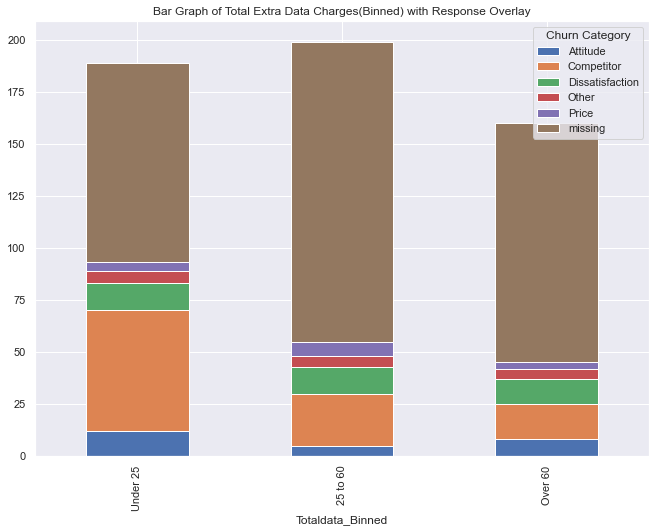

In [56]:
###Created by VS
crosstab_02 = pd.crosstab(df_combine['Totaldata_Binned'],
                          df_combine['Churn Category'])
crosstab_02.plot(kind='bar', stacked = True, title =
'Bar Graph of Total Extra Data Charges(Binned) with Response Overlay')

In [57]:
#####################################################
###Analysis (VS)
# It is apparent based on the data above people with the provider are not leaving the company because of 
# extra data charges
# The highest proportion is missing which means the customer is still with the company.
# additionally it appears those persons who had extra charges for less than 25 GB of uses continued to stay with
# the company in proportion to the other categories. 
#####################################################

In [58]:
#####################################################
# Relationship between a two continous variables (VS)
#####################################################

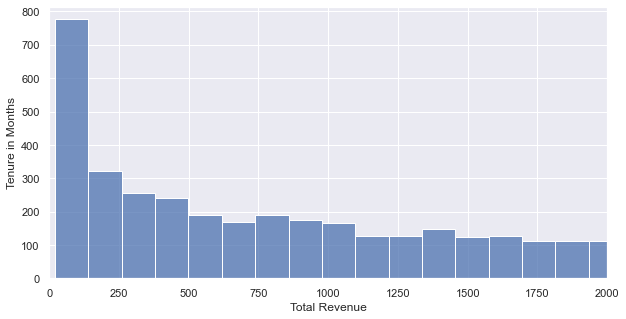

In [59]:
###Created by VS
plt.figure(figsize=(10,5))
plt.xlim(0,2000)
plt.xlabel('Total Revenue')
plt.ylabel('Tenure in Months')
sns.histplot(df_combine['Total Revenue'],bins=100,kde=False)
plt.show()

In [60]:
#########################################################################
###Analysis (VS)
# It is appears that the company makes more money 
#as they bring on newer customers,
# older customers could be locked into their plans and 
#therefore do no bring in increase revenue
# This would not explain the reason for churn but 
#is interesting to see if customer loyalty
# is actually worth monitoring or if a main focus 
#should be on bringing in new customers.
###############################################################

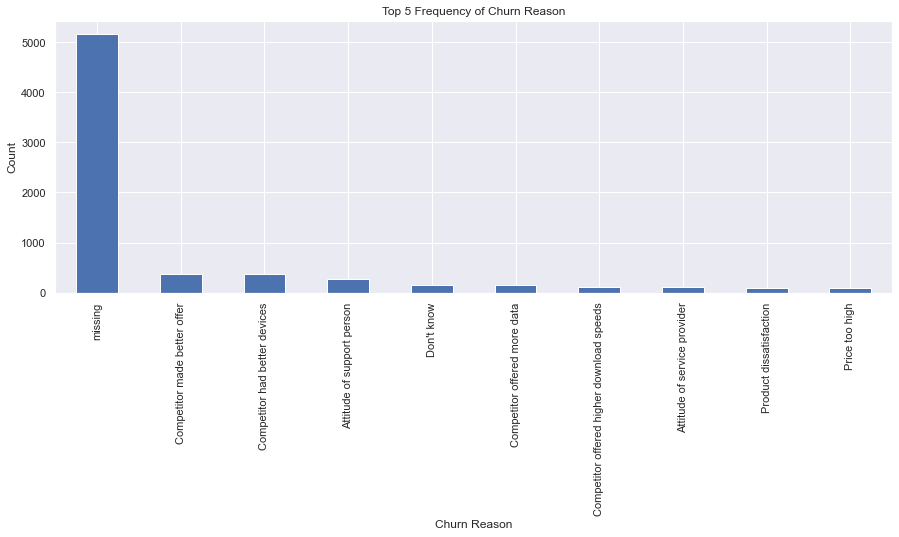

The highest occurrence of churn category is missing, which means did not churn, followed by
competitor made better offer.


In [124]:
# Created by CV
# Box plot of frequency of churn reason
churn_reason = df.groupby('Churn Reason').agg({'Churn Reason': 'count'})
churn_reason = churn_reason['Churn Reason'].sort_values(ascending=False).head(10)

churn_reason.plot(kind='bar', figsize=(15, 5))
plt.title("Top 5 Frequency of Churn Reason")
plt.xlabel("Churn Reason")
plt.ylabel("Count")
plt.show()

print("""The highest occurrence of churn category is missing, which means did not churn, followed by
competitor made better offer.""")

### Two categorical variables
1. Bar plot: Churn Category and Gender

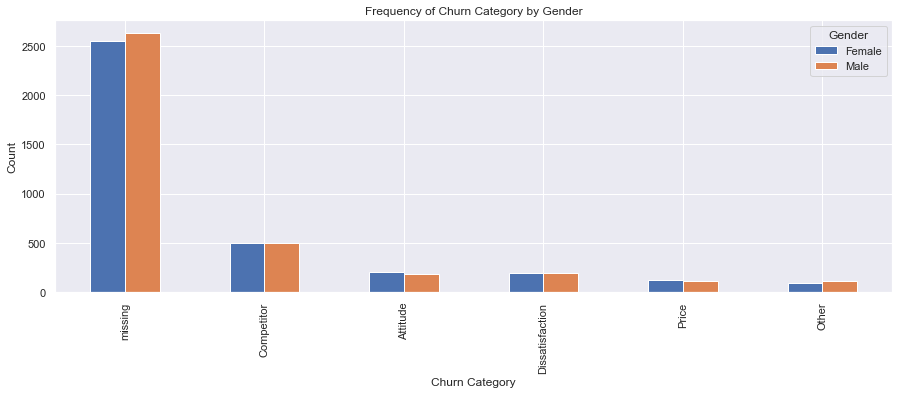

The highest occurrence of churn category is missing, which means did not churn, followed by
competitor for both genders.


In [62]:
# Created by CV
# Relationship between 2 categorical variables: 'Churn Category' and 'Gender'
churncat_count = df['Churn Category'].value_counts().index
ordered_churncat = CategoricalDtype(categories=churncat_count)
df['Churn Category'] = df['Churn Category'].astype(ordered_churncat)
pd.crosstab(df['Churn Category'], df['Gender']).plot(kind="bar", figsize=(15, 5))

plt.title("Frequency of Churn Category by Gender")
plt.xlabel("Churn Category")
plt.ylabel("Count")
plt.show()

print("""The highest occurrence of churn category is missing, which means did not churn, followed by
competitor for both genders.""")

In [64]:
# Created by CV
data_crosstab = pd.crosstab(df['Gender'], df['Churn Category'], margins = False)
data_crosstab

Churn Category,missing,Competitor,Attitude,Dissatisfaction,Price,Other
Gender,,,,,,
Female,2549,502,201,191,125,93
Male,2625,498,185,194,115,113


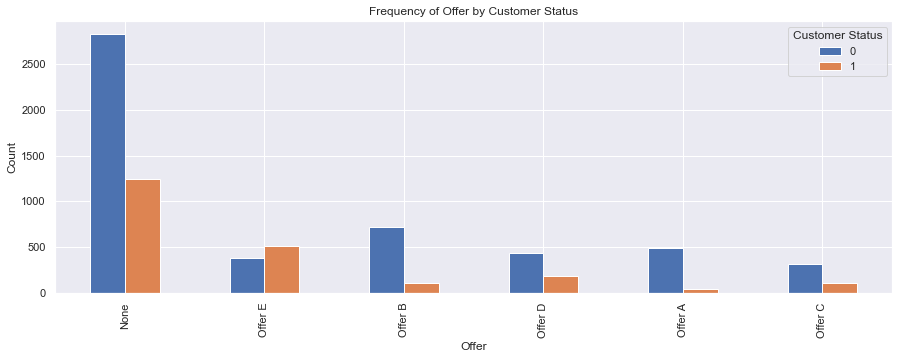

Most customers did not receive an offer, followed by getting Offer E.
No offer resulted in a greater amount of customers staying than churning.
Offer E resulted in a greater amount of customers churning than staying.
Offers A, B, C, and D resulted in a greater amount of customers staying than churning.


In [125]:
# Created by CV
# Relationship between 2 categorical variables: 'Offer' and 'Customer Status'
offer_count = df['Offer'].value_counts().index
ordered_offer = CategoricalDtype(categories=offer_count)
df['Offer'] = df['Offer'].astype(ordered_offer)
pd.crosstab(df['Offer'], df['Customer Status']).plot(kind="bar", figsize=(15, 5))

plt.title("Frequency of Offer by Customer Status")
plt.xlabel("Offer")
plt.ylabel("Count")
plt.show()

print("""Most customers did not receive an offer, followed by getting Offer E.
No offer resulted in a greater amount of customers staying than churning.
Offer E resulted in a greater amount of customers churning than staying.
Offers A, B, C, and D resulted in a greater amount of customers staying than churning.""")

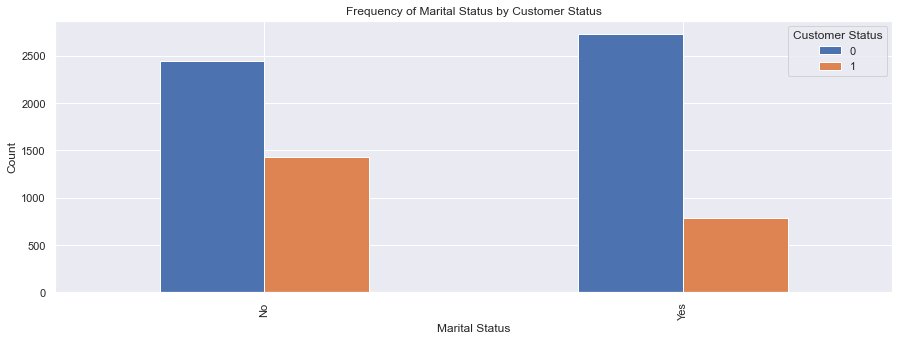

Both unmarried and married groups are most likely to not churn than to churn.


In [128]:
# Created by CV
# Relationship between 2 categorical variables: 'Married' and 'Customer Status'
married_count = df['Married'].value_counts().index
ordered_married = CategoricalDtype(categories=married_count)
df['Married'] = df['Married'].astype(ordered_married)
pd.crosstab(df['Married'], df['Customer Status']).plot(kind="bar", figsize=(15, 5))

plt.title("Frequency of Marital Status by Customer Status")
plt.xlabel("Marital Status")
plt.ylabel("Count")
plt.show()

print("Both unmarried and married groups are most likely to not churn than to churn.")

### Two continuous variables
1. Scatterplot: Age and Monthly Charge
2. Box plot: Age and Monthly Charge, considering Gender

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


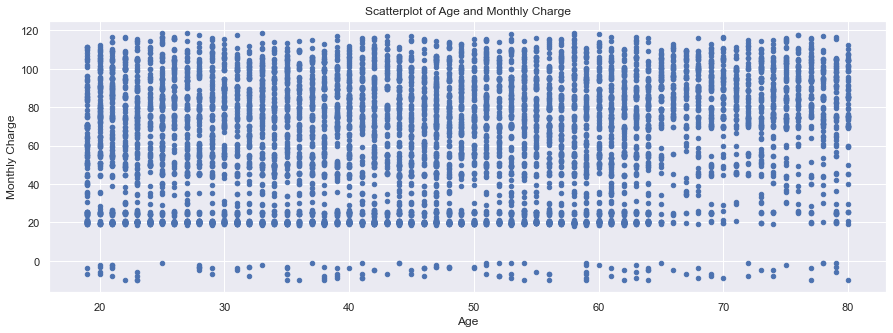

There is no correlation between Age and Monthly Charge.


In [65]:
# Created by CV
# Relationship between 2 continuous variables: 'Age' and 'Monthly Charge'
df.plot.scatter(x = 'Age', y = 'Monthly Charge', marker='o', figsize=(15,5))

plt.title("Scatterplot of Age and Monthly Charge")
plt.xlabel("Age")
plt.ylabel("Monthly Charge")
plt.show()

print("There is no correlation between Age and Monthly Charge.")

Text(0.5, 1.0, 'Relationship between Age and Monthly Charge considering Gender')

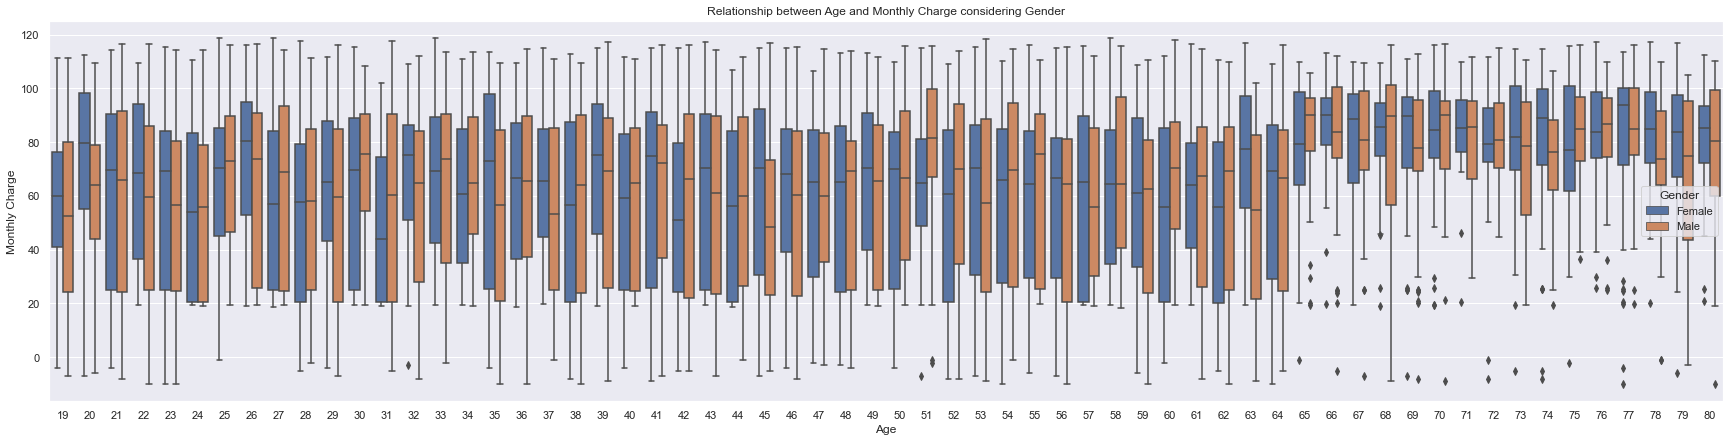

In [66]:
# Created by CV
# Relationship between 2 continuous variables: 'Age' and 'Monthly Charge'
plt.figure(figsize = (30, 7))

sns.boxplot(x="Age", y="Monthly Charge", hue="Gender", data=df)
plt.title("Relationship between Age and Monthly Charge considering Gender")

In [67]:
# Created by CV
data_crosstab = pd.crosstab(df['Age'], df['Monthly Charge'])
data_crosstab

Monthly Charge,-10.00,-9.00,-8.00,-7.00,-6.00,-5.00,-4.00,-3.00,-2.00,-1.00,...,117.35,117.45,117.50,117.60,117.80,118.20,118.35,118.60,118.65,118.75
Age,,,,,,,,,,,,,,,,,,,,,
19,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20,0,0,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,1,0,0,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
22,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,2,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
77,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,0,0,0,0,0,0,0,0,0,2,...,1,0,0,0,0,0,0,0,0,0


### One categorical and one continuous variable
1. Data frame: City and Total Revenue
2. Box plot: Age and Churn Reason

In [147]:
# Created by CV
# Top 5 cities by 'Total Revenue'

top_cities = df.groupby('City').sum().sort_values('Total Revenue', ascending = False)
top_cities.head(5)

,Age,Number of Dependents,Zip Code,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status
City,,,,,,,,,,,,,,,,
Los Angeles,14210,126,28090903,10621.220094,-36909.197838,695,9642,7798.578102,7836.917165,19350.60,672954.25,349.87,2150,220575.04,895329.42,97
San Diego,15540,66,29478522,10510.250613,-37494.030179,365,7682,7772.843448,8321.508791,22899.80,626869.65,867.74,2810,174194.15,803006.06,220
Sacramento,5496,46,11116041,4474.083567,-14087.231833,223,3838,3321.574655,3152.078666,7170.35,257768.60,388.13,1270,97423.60,356074.07,34
San Jose,5182,69,11224775,4402.514430,-14379.729293,252,3619,3095.917241,3296.419250,7790.00,250131.30,357.33,690,84479.90,334943.87,35
San Francisco,5171,57,10447012,4192.439861,-13590.005475,150,3323,3018.662586,2538.888708,7270.95,237659.25,75.57,990,87919.10,326492.78,38


In [69]:
# Created by CV
# Churn Reason for Los Angeles (Top 'Total Revenue' city) for those who churned
la = df[df['City'] == "Los Angeles"]
la = la[la['Customer Status'] == 1] # 1 = Churned

la_churn = pd.DataFrame(la['Churn Reason'].value_counts())
la_churn['Count'] = la_churn['Churn Reason'] # Replace 'Churn Reason' column name with 'Count'
del la_churn['Churn Reason'] # Delete 'Churn Reason' column because replaced with 'Count'

la_churn

,Count
Competitor had better devices,19
Competitor made better offer,11
Competitor offered higher download speeds,11
Competitor offered more data,10
Don't know,9
Price too high,6
Attitude of support person,6
Extra data charges,6
Moved,4
Network reliability,3


In [70]:
la_churn_category = pd.DataFrame(la['Churn Category'].value_counts())
la_churn_category['Count'] = la_churn_category['Churn Category'] # Replace 'Churn Reason' column name with 'Count'
del la_churn_category['Churn Category'] # Delete 'Churn Category' column because replaced with 'Count'

la_churn_category

,Count
Competitor,51
Price,16
Other,13
Dissatisfaction,11
Attitude,6
missing,0


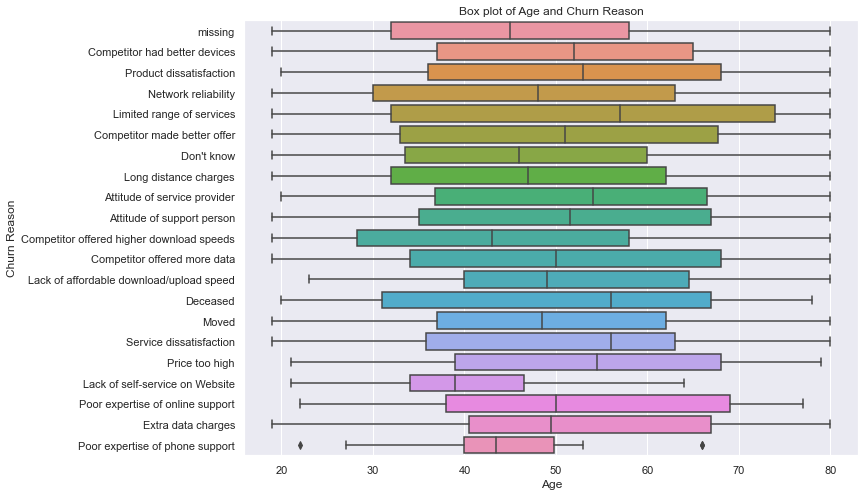

In [71]:
# Relationship between 1 categorical and 1 continuous variable: 'Age' and 'Churn Reason'
sns.boxplot(x="Age", y="Churn Reason", data=df)

plt.title("Box plot of Age and Churn Reason")
plt.xlabel("Age")
plt.ylabel("Churn Reason")
plt.show()

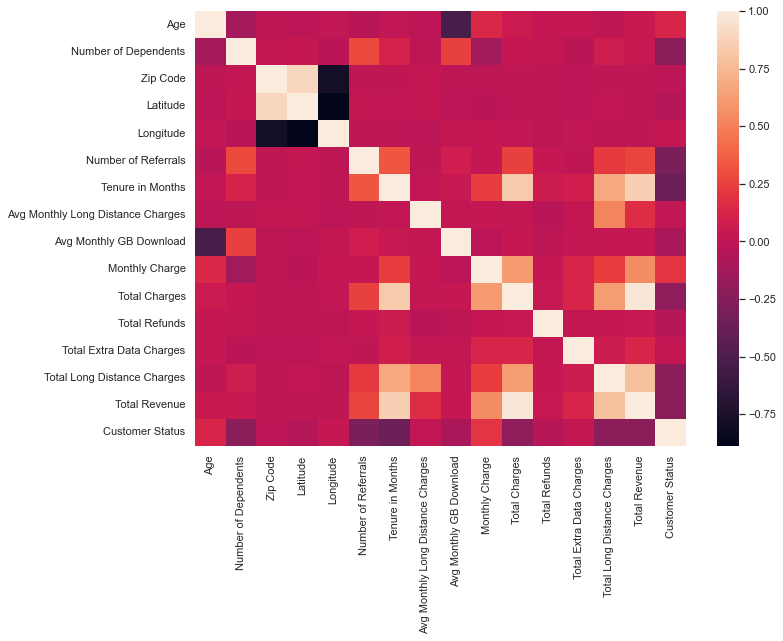

Highly correlated variables:
- Total Charges & Total Revenue
- Total Charges & Tenure in Months
- Total Revenue & Total Charges
- Total Revenue & Tenure in Months
- Zip Code & Latitude


In [72]:
# Created by CV
# Correlation between all variables
sns.heatmap(df.corr())
plt.show()

print("""Highly correlated variables:
- Total Charges & Total Revenue
- Total Charges & Tenure in Months
- Total Revenue & Total Charges
- Total Revenue & Tenure in Months
- Zip Code & Latitude""")

## Binary Classification Model
1. Feature Selection
2. K-Fold Cross Validation and Prediction Modeling
3. Decision Tree
4. Naïve Bayes
5. Random Forest
6. K-means clustering
7. CART
8. C5.0

In [73]:
################################################################################################
# PCA reduction to reduce the number of columns from 8200 down to something more realistic
# to feed to the logistic regression model
################################################################################################
'''
from sklearn import datasets  # to retrieve the iris Dataset
import pandas as pd  # to load the dataframe
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA
import seaborn as sns  # to plot the heat maps


#Standardize the features
#Create an object of StandardScaler which is present in sklearn.preprocessing
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df.select_dtypes(include=[np.number]))) #scaling the data
scaled_data

# clean up NaN
# drop all rows containing NaN
# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/#:~:text=By%20using%20dropna()%20method,you%20should%20use%20inplace%3DTrue%20.
scaled_data = scaled_data.dropna()



#Check the Co-relation between features without PCA
sns.heatmap(scaled_data.corr())


#Applying PCA
#Taking no. of Principal Components as 3
pca = PCA(n_components = 3)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3'])
data_pca.head()



#Checking Co-relation between features after PCA
sns.heatmap(data_pca.corr())
'''


"\nfrom sklearn import datasets  # to retrieve the iris Dataset\nimport pandas as pd  # to load the dataframe\nfrom sklearn.preprocessing import StandardScaler  # to standardize the features\nfrom sklearn.decomposition import PCA  # to apply PCA\nimport seaborn as sns  # to plot the heat maps\n\n\n#Standardize the features\n#Create an object of StandardScaler which is present in sklearn.preprocessing\nscalar = StandardScaler()\nscaled_data = pd.DataFrame(scalar.fit_transform(df.select_dtypes(include=[np.number]))) #scaling the data\nscaled_data\n\n# clean up NaN\n# drop all rows containing NaN\n# https://sparkbyexamples.com/pandas/pandas-drop-rows-with-nan-values-in-dataframe/#:~:text=By%20using%20dropna()%20method,you%20should%20use%20inplace%3DTrue%20.\nscaled_data = scaled_data.dropna()\n\n\n\n#Check the Co-relation between features without PCA\nsns.heatmap(scaled_data.corr())\n\n\n#Applying PCA\n#Taking no. of Principal Components as 3\npca = PCA(n_components = 3)\npca.fit(scaled_d

### Feature Selection

Removing features results in a better and faster performing model

Options to try to extract the best features:

1: Percent Missing Values - encode missing values as a separate category "missing"
>> Refer to line 74 above, used SimpleImputer 

2: Amount of Variation - Drop variables that have low variance and won't indicate much for training

3: Pairwise correlation - If two features are highly correlated, then you can drop one because it won't be losing that much information in terms of what your model can learn from

4: Principal Component Analysis
>> This is not a high dimensionality dataset, so we skip this.

5: Cluster analysis
>> We are conducting binary classification, skip this for now.

6: Correlation (with the target) - Drop variables that have low correlation with the target

7: Forward selection - pick one feature, do cross validation, add next best feature by some criteria

8: Backward elimination (RFE) - start with all features, then subtract one until meet stopping criteria

9: Stepwise selection - combination of forward/backward selection

10: LASSO - algorithm for regularized linear model, change regularization parameter

11: Tree-based selection - random forests automatically computes feature importances by certain threshold
>> See Modeling section with feature importance for Decision Tree, Random Forest

12: SelectKBest to determine the highest impact features or combination of

Caution: Any of these features may have useful interaction with the target
ie. maybe two that are viewed as not correlated to the target, combined
may have correlation


In [74]:
df['City']

0       Frazier Park
1           Glendale
2         Costa Mesa
3           Martinez
4          Camarillo
            ...     
3729       San Diego
3764    Ladera Ranch
1658         Gualala
6426       Tollhouse
1877       San Diego
Name: City, Length: 7391, dtype: object

In [75]:
# 2: Amount of Variation - Drop variables that have low variance and won't indicate much for training

var_tab = df_ohed.var()

keep = []
columns = df_ohed.columns

print('\nTable of Variances (Features to Keep):')

for i in range(0,len(var_tab)):
    if var_tab[i]>=0.006: #setting the threshold as 1%
        keep.append(columns[i])
        print(columns[i])

#print('\nTable of Variances (Features to Keep):')
#print(keep)


Table of Variances (Features to Keep):
Customer ID
Age
Number of Dependents
City
Zip Code
Latitude
Longitude
Number of Referrals
Tenure in Months
Avg Monthly Long Distance Charges
Avg Monthly GB Download
Monthly Charge
Total Charges
Total Refunds
Total Extra Data Charges
Total Long Distance Charges
Total Revenue
Customer Status
Gender_Female
Gender_Male
Married_No
Married_Yes
Offer_None
Offer_Offer A
Offer_Offer B
Offer_Offer C
Offer_Offer D
Offer_Offer E
Phone Service_No
Phone Service_Yes
Multiple Lines_No
Multiple Lines_Yes
Multiple Lines_missing
Internet Service_No
Internet Service_Yes
Internet Type_Cable
Internet Type_DSL
Internet Type_Fiber Optic
Internet Type_missing
Online Security_No
Online Security_Yes
Online Security_missing
Online Backup_No
Online Backup_Yes
Online Backup_missing
Device Protection Plan_No
Device Protection Plan_Yes
Device Protection Plan_missing
Premium Tech Support_No
Premium Tech Support_Yes
Premium Tech Support_missing
Streaming TV_No
Streaming TV_Yes
St

/var/folders/wv/42dn23fd1cb0czpvqdnb6zw00000gn/T/ipykernel_13656/2958220177.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  var_tab = df_ohed.var()


In [76]:
###ISSUE HERE, 'City' removed because causing error, not found in DF. ###
###Trouble shooting necessary

'''
3: Pairwise correlation - If two features are highly correlated, then you can 
drop one because it won't be losing that much information in terms of what your 
model can learn from

6: Correlation (with the target) - Drop variables that have low correlation 
with the target
'''

if z_correlation_matrix == True:
    #plt.rcParams.update({'font.size': 8})
    corr_df_cat = df_ohed.drop(columns=['Customer ID', 'Age', 'Zip Code', 'Latitude', 'Longitude'])
    #corr_df_cat = df[['Gender', 'Married','City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Churn Category', 'Customer Status']]
    #nominal.associations(corr_df_cat, nominal_columns = 'auto', figsize=(15, 15), annot =True)

    # Your data should be a pandas dataframe for this example
    corr_matrix = corr_df_cat.corr()
    matrix = corr_matrix["Customer Status"].sort_values(ascending=False)
    # why does the above turn Customer Status into nan?
    #matrix = matrix.unstack()
    matrix = matrix[abs(matrix) >= 0]

    # sideways bar chart of anything

    corr_matrix.to_csv('correlation_matrix.csv')
    print("======================  CORRELATION TO TARGET - TOP 50 ==========================================")
    print(matrix.head(50))

    print("======================  CORRELATION TO TARGET - BOTTOM 25 ==========================================")
    print(matrix.tail(25))


    # Indexing with numbers on a numpy matrix will probably be faster
    corr = corr_matrix.values
    rows, cols = corr.shape

    print("======================  PAIRWISE CORRELATION - FEATURES HIGHLY CORRELATED TO EACH OTHER - CUT OFF AT 0.4 ==========================================")
    for i in range(cols):
        for j in range(i + 1, cols):
            if corr[i, j] > 0.4:
                print(corr_matrix.columns[i] + ', ' + corr_matrix.index[j] + ': ' + str(corr[i, j]))


    #print("====================== CORRELATION MATRIX - FEATURES TO TARGET  ================")
    #print(matrix.head(50))
    #print("correlation matrix tail: ")
    #print(matrix.tail(25))



======================  CORRELATION TO TARGET - TOP 50 ==========================================
Customer Status                                           1.000000
Churn Category_Competitor                                 0.612690
Contract_Month-to-Month                                   0.448427
Churn Category_Dissatisfaction                            0.363590
Churn Category_Attitude                                   0.359417
Churn Reason_Competitor had better devices                0.358817
Churn Reason_Competitor made better offer                 0.357616
Online Security_No                                        0.342637
Premium Tech Support_No                                   0.337281
Churn Reason_Attitude of support person                   0.298767
Churn Category_Price                                      0.292399
Internet Type_Fiber Optic                                 0.279623
Churn Category_Other                                      0.270988
Online Backup_No               

In [77]:
# Save dataframe to file, reupload in the 2_ExploratoryDataAnalysis.ipynb
# This keeps everything separated and easier to maintain

#df_ohed.to_csv('1_DataPreprocessing_df_ohed.csv', index = False)
#from google.colab import files
#files.download("OMdb_merged.csv")

### K-Fold Cross Validation and Prediction Modeling

In [78]:
################################################################################################
# 5 K-Fold Cross Validation
# Cross Validation generates higher accuracy on out of sample data
# Reference: Scoring Parameters:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
################################################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

print("Cross Validation Results: ")

# As a mini-test, the cross validation was run with features that did not have
# a high correlation to target, see the line below.  Accuracy came out to 77% which
# is what we would expect with non-correlated features as input to the model.
# 77% accuracy selected_cols = ['Age', 'Internet Service_No', 'Contract_Two Year', 'Tenure in Months']

# List of best features used to predict customer churn
selected_cols = ['Contract_Month-to-Month',
                 'Churn Category_Dissatisfaction',
                 'Churn Category_Attitude',
                 'Churn Reason_Competitor made better offer',
                 'Churn Category_Price',
                 'Churn Category_Other',
                 'Internet Service_Yes',
                 'Churn Reason_Competitor offered higher download speeds',
                 'Paperless Billing_Yes',
                 'Payment Method_Bank Withdrawal',
                 'Churn Reason_Product dissatisfaction',
                 'Online Security_No',
                 'Premium Tech Support_No',
                 #'Married_No',
                 'Churn Reason_Limited range of services',
                 'Churn Reason_Poor expertise of online support',
                 'Churn Reason_Lack of affordable download/upload speed']

X = df_ohed[selected_cols]
y = df_ohed['Customer Status']

# 10-fold cross-validation with logistic regression
# see documentation: liblinear good for small datasets
logreg = LogisticRegression(solver='liblinear')
accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()
avg_precision = cross_val_score(logreg, X, y, cv=10, scoring='average_precision').mean()
f1 = cross_val_score(logreg, X, y, cv=10, scoring='f1').mean()
precision = cross_val_score(logreg, X, y, cv=10, scoring='precision').mean()
recall = cross_val_score(logreg, X, y, cv=10, scoring='recall').mean()
roc_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

print(f'Logistic Regression: training accuracy score: {accuracy}')
print(f'Logistic Regression: training avg precision score: {avg_precision}')
print(f'Logistic Regression: training f1 score: {f1}')
print(f'Logistic Regression: training precision score: {precision}')
print(f'Logistic Regression: training recall score: {recall}')
print(f'Logistic Regression: training roc auc score: {roc_auc}')


# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
#print("KNN:")
#print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())
accuracy = cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
avg_precision = cross_val_score(knn, X, y, cv=10, scoring='average_precision').mean()
f1 = cross_val_score(knn, X, y, cv=10, scoring='f1').mean()
precision = cross_val_score(knn, X, y, cv=10, scoring='precision').mean()
recall = cross_val_score(knn, X, y, cv=10, scoring='recall').mean()
roc_auc = cross_val_score(knn, X, y, cv=10, scoring='roc_auc').mean()

print(f'KNN: training accuracy score: {accuracy}')
print(f'KNN: training avg precision score: {avg_precision}')
print(f'KNN: training f1 score: {f1}')
print(f'KNN: training precision score: {precision}')
print(f'KNN: training recall score: {recall}')
print(f'KNN: training roc auc score: {roc_auc}')

# Perform 7-fold cross validation
clf = tree.DecisionTreeClassifier(max_depth=i)
#print("Decision Tree:")
#print(cross_val_score(estimator=clf, X=X, y=y, cv=7, n_jobs=4).mean())
accuracy = cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
avg_precision = cross_val_score(clf, X, y, cv=10, scoring='average_precision').mean()
f1 = cross_val_score(clf, X, y, cv=10, scoring='f1').mean()
precision = cross_val_score(clf, X, y, cv=10, scoring='precision').mean()
recall = cross_val_score(clf, X, y, cv=10, scoring='recall').mean()
roc_auc = cross_val_score(clf, X, y, cv=10, scoring='roc_auc').mean()

print(f'Decision Tree: training accuracy score: {accuracy}')
print(f'Decision Tree: training avg precision score: {avg_precision}')
print(f'Decision Tree: training f1 score: {f1}')
print(f'Decision Tree: training precision score: {precision}')
print(f'Decision Tree: training recall score: {recall}')
print(f'Decision Tree: training roc auc score: {roc_auc}')


# Perform 7-fold cross validation with Random Forest model
rfc = RandomForestClassifier(n_estimators = 100, random_state = 123,
                             max_depth = 9, criterion = "gini")
#print("Random Forest:")
#print(cross_val_score(estimator=rfc, X=X, y=y, cv=7, n_jobs=4).mean())
accuracy = cross_val_score(rfc, X, y, cv=10, scoring='accuracy').mean()
avg_precision = cross_val_score(rfc, X, y, cv=10, scoring='average_precision').mean()
f1 = cross_val_score(rfc, X, y, cv=10, scoring='f1').mean()
precision = cross_val_score(rfc, X, y, cv=10, scoring='precision').mean()
recall = cross_val_score(rfc, X, y, cv=10, scoring='recall').mean()
roc_auc = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc').mean()

print(f'Random Forest: training accuracy score: {accuracy}')
print(f'Random Forest: training avg precision score: {avg_precision}')
print(f'Random Forest: training f1 score: {f1}')
print(f'Random Forest: training precision score: {precision}')
print(f'Random Forest: training recall score: {recall}')
print(f'Random Forest: training roc auc score: {roc_auc}')


Cross Validation Results: 
Logistic Regression: training accuracy score: 0.9389460428755643
Logistic Regression: training avg precision score: 0.9369077964748053
Logistic Regression: training f1 score: 0.8696103022135115
Logistic Regression: training precision score: 1.0
Logistic Regression: training recall score: 0.7699097234201597
Logistic Regression: training roc auc score: 0.9706225193828834
KNN: training accuracy score: 0.8845728562217923
KNN: training avg precision score: 0.8744840283297103
KNN: training f1 score: 0.737002685280187
KNN: training precision score: 0.950794589400547
KNN: training recall score: 0.6083836467138175
KNN: training roc auc score: 0.9402236058899538
Decision Tree: training accuracy score: 0.9389460428755643
Decision Tree: training avg precision score: 0.9363964816812169
Decision Tree: training f1 score: 0.8696103022135115
Decision Tree: training precision score: 1.0
Decision Tree: training recall score: 0.7699097234201597
Decision Tree: training roc auc sc

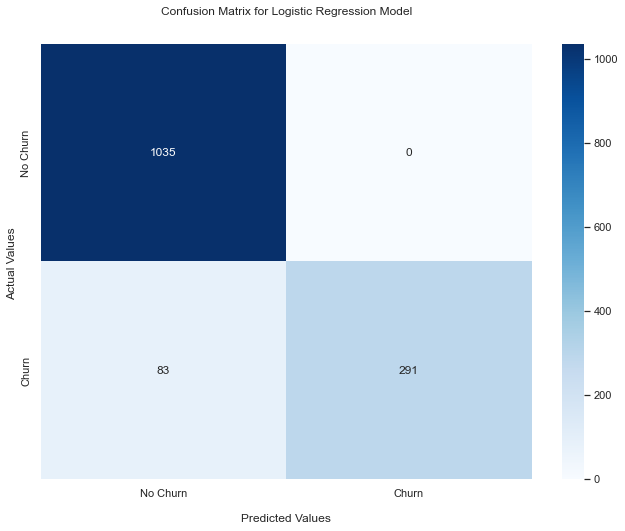

<Figure size 792x576 with 0 Axes>

In [79]:
###############################################################################
# Train Individual Logistic Regression Model
###############################################################################
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Setup the dataframe for input features and the target variable
X = df_ohed[selected_cols]
y = df_ohed['Customer Status']

# Split up the test data by 20% portion, use stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 2020, stratify = y)

# Create the Logistic Regression Model and train it
Logreg = LogisticRegression()
log = Logreg.fit(X_train, y_train)

# Use test dataset to predict using the model
y_pred = log.predict(X_test)

# Get confusion matrix numbers
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Construct the confusion matrix out of a heatmap in Seaborn
plt.figure()   # this clears the panel
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix for Logistic Regression Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Label the axes
ax.xaxis.set_ticklabels(['No Churn','Churn'])
ax.yaxis.set_ticklabels(['No Churn','Churn'])

# Display and Save the confusion matrix to a file
plt.show()
plt.savefig('Confusion Matrix - Logistic Regression.png')

In [80]:
dfDT = df_combine.drop(['Totaldata_Binned'],axis=1)

In [81]:
dfDT.dtypes

Customer ID                           object
Gender                                object
Married                               object
Number of Dependents                   int64
City                                  object
Zip Code                               int64
Latitude                             float64
Longitude                            float64
Offer                                 object
Phone Service                         object
Multiple Lines                        object
Internet Service                      object
Internet Type                         object
Online Security                       object
Online Backup                         object
Device Protection Plan                object
Premium Tech Support                  object
Streaming TV                          object
Streaming Movies                      object
Streaming Music                       object
Unlimited Data                        object
Contract                              object
Paperless 

### Decision Tree

In [82]:
###############################################################################
# Build CART Decision Trees (VS)
###############################################################################

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

import statsmodels.tools.tools as stattools
from sklearn.tree import DecisionTreeClassifier, export_graphviz



In [83]:
dfDT['Customer Status'].replace([0, 1],
                        ["No", "Yes"], inplace=True)

In [84]:
X = dfDT[['Monthly Charge', 'Total Revenue']]
y = dfDT[['Customer Status']]

In [85]:
dfDT['Customer Status']

0        No
1        No
2       Yes
3       Yes
4       Yes
       ... 
7038     No
7039    Yes
7040     No
7041     No
7042     No
Name: Customer Status, Length: 7043, dtype: object

In [86]:
dt = DecisionTreeClassifier(criterion='gini', max_leaf_nodes=5).fit(X, y)

[Text(0.4444444444444444, 0.875, 'Total Revenue <= 723.045\ngini = 0.39\nsamples = 7043\nvalue = [5174, 1869]\nclass = No'),
 Text(0.2222222222222222, 0.625, 'Monthly Charge <= 65.65\ngini = 0.494\nsamples = 1931\nvalue = [1069, 862]\nclass = No'),
 Text(0.1111111111111111, 0.375, 'gini = 0.424\nsamples = 1272\nvalue = [884, 388]\nclass = No'),
 Text(0.3333333333333333, 0.375, 'gini = 0.404\nsamples = 659\nvalue = [185, 474]\nclass = Yes'),
 Text(0.6666666666666666, 0.625, 'Monthly Charge <= 69.925\ngini = 0.316\nsamples = 5112\nvalue = [4105, 1007]\nclass = No'),
 Text(0.5555555555555556, 0.375, 'gini = 0.139\nsamples = 2147\nvalue = [1986, 161]\nclass = No'),
 Text(0.7777777777777778, 0.375, 'Total Revenue <= 3842.295\ngini = 0.408\nsamples = 2965\nvalue = [2119, 846]\nclass = No'),
 Text(0.6666666666666666, 0.125, 'gini = 0.497\nsamples = 1100\nvalue = [589, 511]\nclass = No'),
 Text(0.8888888888888888, 0.125, 'gini = 0.295\nsamples = 1865\nvalue = [1530, 335]\nclass = No')]

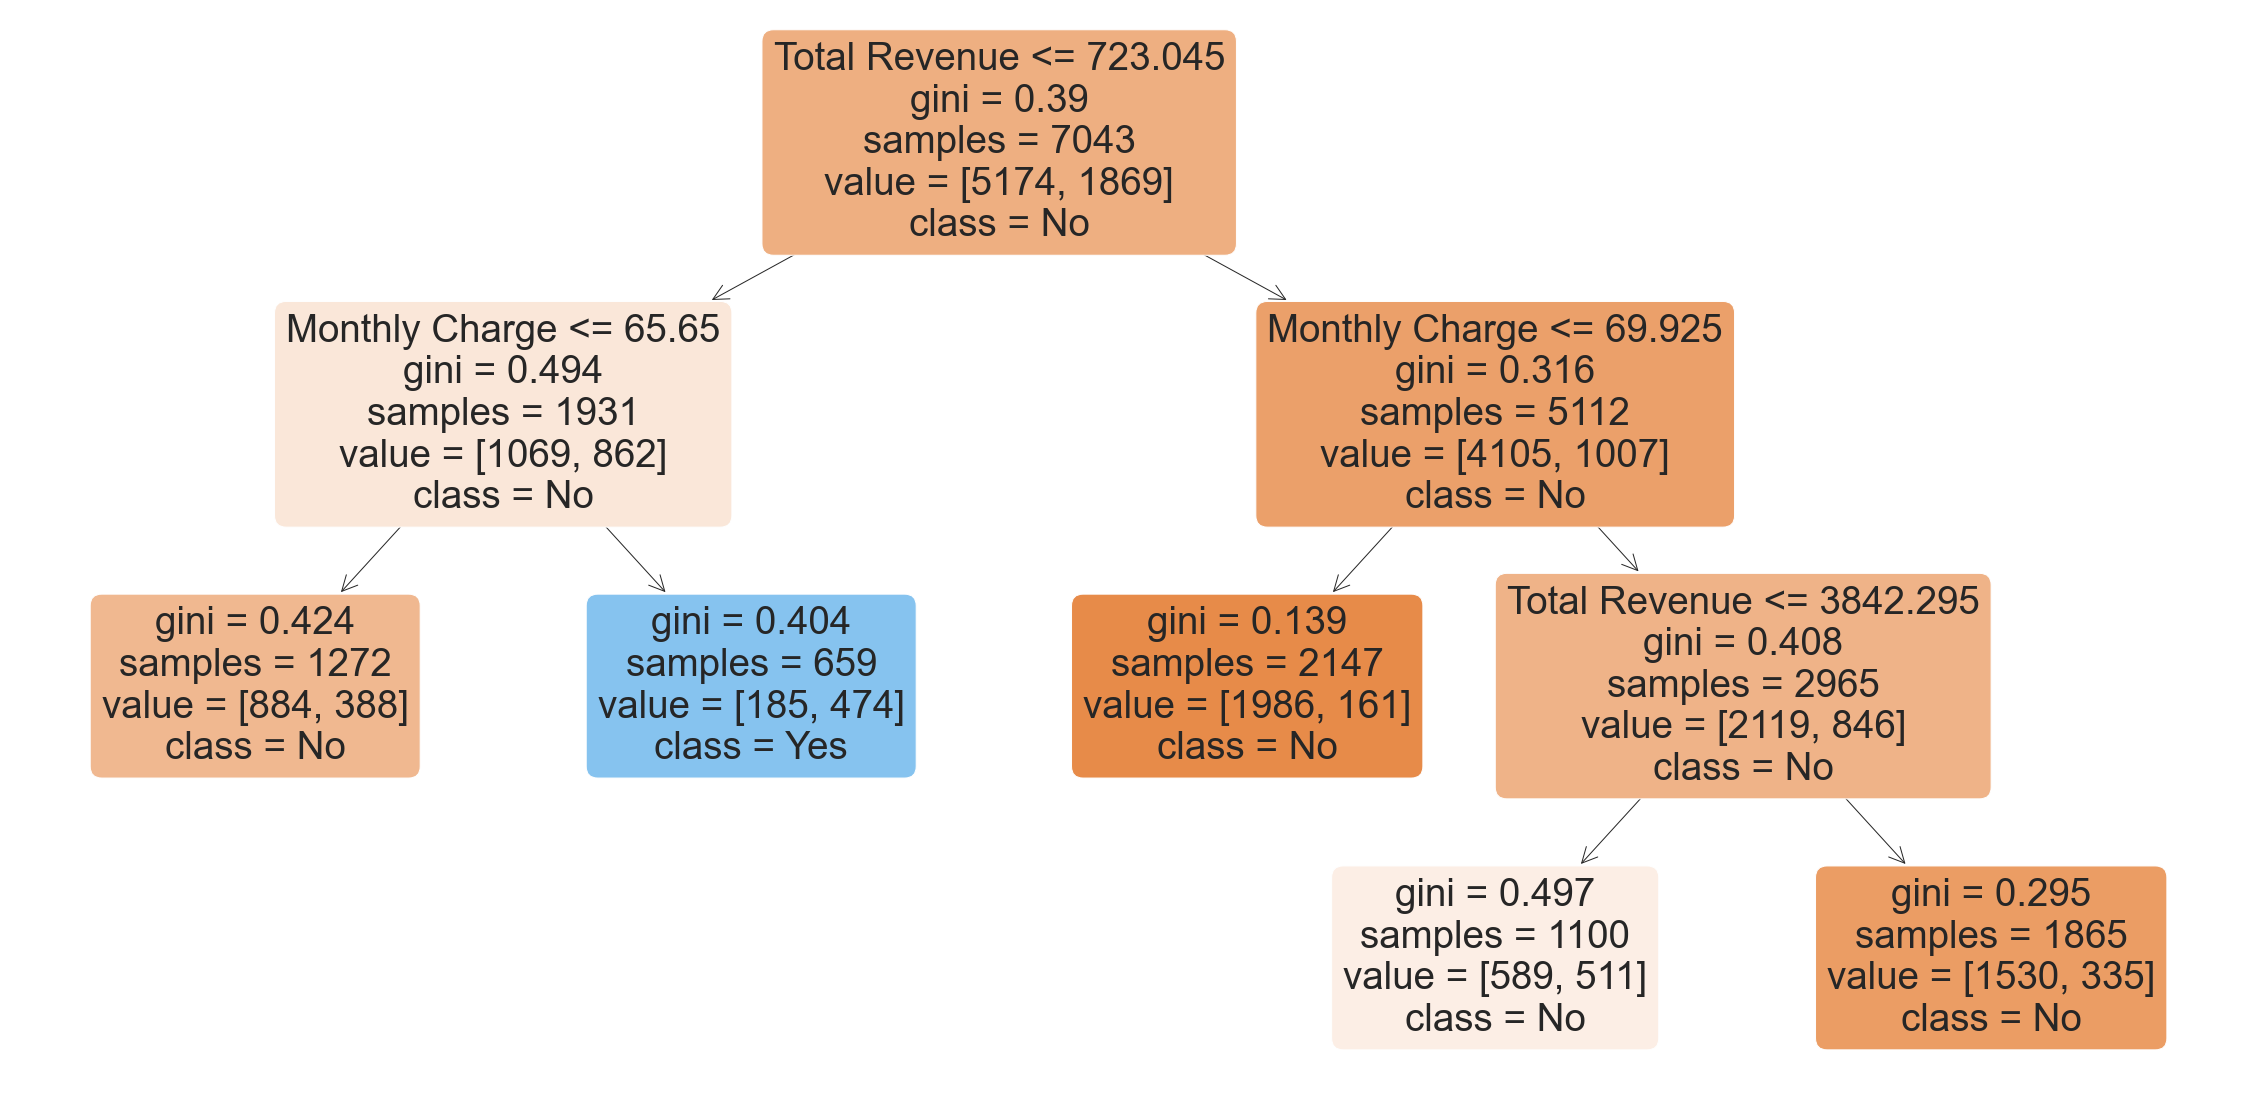

In [87]:
plt.figure(figsize=(40,20))
plot_tree(dt,
          feature_names = X.columns,
          class_names=y['Customer Status'].unique(),
          filled=True,
          rounded = True)

In [88]:
predictions = dt.predict(X)
predictions

array(['No', 'No', 'Yes', ..., 'No', 'No', 'No'], dtype=object)

In [89]:
cm = confusion_matrix(y, predictions)
cm

array([[4989,  185],
       [1395,  474]])

In [90]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

In [91]:
print('TN: ', TN,
      '\nFP: ', FP,
      '\nFN: ', FN,
      '\nTP: ', TP,)

TN:  4989 
FP:  185 
FN:  1395 
TP:  474


### Naïve Bayes Classifier

In [92]:
#Vs

import random

from sklearn.model_selection import train_test_split



In [93]:
nbdf = dfDT[['Customer Status', 'Total Charges', 'Age', 'Total Revenue']]

In [94]:
nbdf['Customer Status'].replace([0, 1],
                        ["No", "Yes"], inplace=True)

/var/folders/wv/42dn23fd1cb0czpvqdnb6zw00000gn/T/ipykernel_13656/2608015480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nbdf['Customer Status'].replace([0, 1],


In [95]:
nbdf_train, nbdf_test = train_test_split(nbdf, 
                                         test_size = 0.25,
                                         random_state = 7)

In [96]:
print('Original number of instances before partitioning: ', nbdf.shape[0],
      '\nNumber of instances in Training set: ', nbdf_train.shape[0],
      '\nNumber of instances in Test set: ', nbdf_test.shape[0])

Original number of instances before partitioning:  7043 
Number of instances in Training set:  5282 
Number of instances in Test set:  1761


In [97]:
print('Proportion of training instances: ', nbdf_train.shape[0]/nbdf.shape[0]*100,
      '\nProportion of test instances: ', nbdf_test.shape[0]/nbdf.shape[0]*100)

Proportion of training instances:  74.99645037626011 
Proportion of test instances:  25.003549623739886


In [98]:
nbdf_train['Customer Status'].value_counts()

No     3876
Yes    1406
Name: Customer Status, dtype: int64

In [99]:
from sklearn.naive_bayes import MultinomialNB

In [100]:
X_train2 = nbdf_train[['Total Charges', 'Age', 'Total Revenue']]
y_train2 = nbdf_train['Customer Status']

In [101]:
nbdf.dtypes

Customer Status     object
Total Charges      float64
Age                  int64
Total Revenue      float64
dtype: object

In [102]:
nb = MultinomialNB().fit(X_train2, y_train2)

In [103]:
X_test2 = nbdf_test[['Total Charges', 'Age', 'Total Revenue']]
y_test2 = nbdf_test['Customer Status']

In [104]:
predictions2 = nb.predict(X_test2)

In [105]:
predictions2

array(['Yes', 'No', 'No', ..., 'Yes', 'No', 'No'], dtype='<U3')

In [106]:
from sklearn.metrics import confusion_matrix

In [107]:
cm = confusion_matrix(y_test2, predictions2)

In [108]:
cm

array([[724, 574],
       [136, 327]])

In [109]:
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print('TN: ', TN,
      '\nFP: ', FP,
      '\nFN: ', FN,
      '\nTP: ', TP)

TN:  724 
FP:  574 
FN:  136 
TP:  327


### Random Forest

In [110]:
# Created by CV

# Bin 'Age' column categories:
# Ages 0 to 3: Toddler
# Ages 4 to 17: Child
# Ages 18 to 25: Young Adult
# Ages 26 to 64: Adult
# Ages 65 to 99: Elder

# New_df: Data frame with 'Age' column values replaced to binned column categories
new_df = df_combine.copy()
new_df['Age'] = pd.cut(new_df['Age'], bins=[0,3,17,25,64,99], 
                       labels=['Toddler', 'Child', 'Young Adult', 'Adult', 'Elder'])

In [111]:
# Created by CV
# Random Forest: Predict 'Customer Status' using 'Age' and 'Monthly Charge'

# Let X = predictor variable and y = target variable
X_train = new_df[['Age', 'Monthly Charge']]
y_train = new_df[['Customer Status']]

mar_np = np.array(new_df['Age'])
(mar_cat, mar_cat_dict) = stattools.categorical(mar_np, drop=True, dictnames=True)
mar_cat_pd = pd.DataFrame(mar_cat)
X_train = pd.concat((new_df[['Monthly Charge']], mar_cat_pd), axis=1)

X_names = ['Toddler', 'Child', 'Young Adult', 'Adult', 'Elder']
y_names = [0, 1]

/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tools/tools.py:152: FutureWarning: categorical is deprecated. Use pandas Categorical to represent categorical data and can get_dummies to construct dummy arrays. It will be removed after release 0.13.
  warnings.warn(


In [112]:
rfy = np.ravel(y_train)
rf01 = RandomForestClassifier(n_estimators = 100, criterion="gini").fit(X_train,rfy)
predictions = rf01.predict(X_train)
predictions

/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([0, 0, 1, ..., 0, 0, 0])

In [113]:
# Confusion matrix of Random Forest
cm = confusion_matrix(y_train, predictions)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print('TN:', TN,
'\nFP:', FP,
'\nFN:', FN,
'\nTP:', TP,)

TN: 4899 
FP: 275 
FN: 858 
TP: 1011


In [114]:
# Random Forest Evaluation Table
accuracy = (4869 + 1043) / (4869 + 305 + 826 + 1043)
error_rate = 1 - accuracy
sensitivity = 1043 / (826 + 1043)
specificity = 4869 / 5174
precision = 1043 / 1330
F_1 = 2 * (precision*sensitivity)/(precision+sensitivity)
F_2 = 5 * (precision*sensitivity)/((4*precision)+sensitivity)
F_05 = 1.25 * (precision*sensitivity)/((0.25*precision)+sensitivity)

print("""Random Forest Evaluation Table:

- Accuracy = (TN + TP) / (TN + FN + FP + TP)
           = (4869 + 1043) / (4869 + 305 + 826 + 1043)
           = 5912 / 7043
           = 0.839415022
        
- Error rate = 1 - Accuracy
             = 1 - (5912/7043)
             = 0.16058497799

- Sensitivity = TP / TAP
              = 1043 / (826 + 1043)
              = 0.55805243445

- Specificity = TN / TAN
              = 4869 / 5174
              = 0.9410514109
              
- Precision = TP / TPP
            = 1043 / 1330
            = 0.78421052631

- F_1 = 2 * ((Precision * Recall) / (Precision + Recall))
      = 2 * (((1043/1330) * (4869/5174)) / ((1043/1330) + (4869/5174)))
      = 0.85550188793

- F_2 = 5 * ((Precision * Recall) / ((4 * Precision) + Recall))
      = 5 * ((1043/1330 * 4869/5174) / ((4 * (1043/1330)) + 4869/5174))
      = 0.90485739672
      
- F_0.5 = 1.25 * ((Precision * Recall) / ((0.25 * Precision) + Recall))
        = 1.25 * ((1043/1330 * 4869/5174) / ((0.25 * (1043/1330)) + 4869/5174))
        = 0.81125208717""")

Random Forest Evaluation Table:

- Accuracy = (TN + TP) / (TN + FN + FP + TP)
           = (4869 + 1043) / (4869 + 305 + 826 + 1043)
           = 5912 / 7043
           = 0.839415022
        
- Error rate = 1 - Accuracy
             = 1 - (5912/7043)
             = 0.16058497799

- Sensitivity = TP / TAP
              = 1043 / (826 + 1043)
              = 0.55805243445

- Specificity = TN / TAN
              = 4869 / 5174
              = 0.9410514109
              
- Precision = TP / TPP
            = 1043 / 1330
            = 0.78421052631

- F_1 = 2 * ((Precision * Recall) / (Precision + Recall))
      = 2 * (((1043/1330) * (4869/5174)) / ((1043/1330) + (4869/5174)))
      = 0.85550188793

- F_2 = 5 * ((Precision * Recall) / ((4 * Precision) + Recall))
      = 5 * ((1043/1330 * 4869/5174) / ((4 * (1043/1330)) + 4869/5174))
      = 0.90485739672
      
- F_0.5 = 1.25 * ((Precision * Recall) / ((0.25 * Precision) + Recall))
        = 1.25 * ((1043/1330 * 4869/5174) / ((0.25 * (1043/133

In [115]:
# Contingency table of Random Forest
contingency_table = pd.crosstab(new_df['Customer Status'], predictions)
contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0).astype(int)
contingency_table

col_0,0,1,Total
Customer Status,,,
0,4899,275,5174
1,858,1011,1869
Total,5757,1286,7043


### K-means Clustering

In [116]:
# Created by CV
# K-means clustering: 'Married' and 'Age'
# 'Married' column converted to binary values (0=No, 1=Yes)
df_combine = df_combine.replace({'Married': {'No': 0, 'Yes': 1}})

X = df_combine[['Married', 'Age']]
Xz = pd.DataFrame(stats.zscore(X), columns=['Married', 'Age'])

kmeans01 = KMeans(n_clusters = 2).fit(Xz)

# Cluster: Cluster membership variable
cluster = kmeans01.labels_

# Separate the records into two groups based on cluster membership (Cluster 1: Not married, Cluster 2: Married)
Cluster1 = Xz.loc[cluster == 0]
Cluster1.describe()

,Married,Age
count,3.402000e+03,3402.000000
mean,1.034530e+00,-0.003792
std,2.664927e-14,1.014336
min,1.034530e+00,-1.642454
25%,1.034530e+00,-0.866296
50%,1.034530e+00,-0.030433
75%,1.034530e+00,0.805430
max,1.034530e+00,1.999519


In [117]:
# Created by CV
Cluster2 = Xz.loc[cluster == 1]
Cluster2.describe()

,Married,Age
count,3.641000e+03,3641.000000
mean,-9.666223e-01,0.003543
std,2.365100e-14,0.986683
min,-9.666223e-01,-1.642454
25%,-9.666223e-01,-0.806591
50%,-9.666223e-01,-0.030433
75%,-9.666223e-01,0.805430
max,-9.666223e-01,1.999519


### CART Decision Tree

In [149]:
# Created by CV
# CART model - WIP (ERROR MESSAGE APPEARING) ****************************************

y_train = new_df[['Customer Status']]

# Dummy variables for Marital status
mar_np = np.array(new_df['Age'])
(mar_cat, mar_cat_dict) = stattools.categorical(mar_np, drop=True, dictnames = True)

mar_cat_pd = pd.DataFrame(mar_cat)
X_train = pd.concat((new_df[['Monthly Charge']], mar_cat_pd), axis = 1)

X_names = ['Toddler', 'Child', 'Young Adult', 'Adult', 'Elder']
y_names = [0, 1]

# Maximum leaf node value: 5 (Can be adjusted)
cart01 = DecisionTreeClassifier(criterion = "gini", max_leaf_nodes=5).fit(X_train,y_train)
predIncomeCART = cart01.predict(X_train)

#export_graphviz(cart01, out_file = "/Users/christinevu/Downloads/cart01.dot",
#                feature_names=X_names, class_names=y_names)

#path2 = '/Users/christinevu/Downloads/cart01.dot'
#s2 = Source.from_file(path)
#s2.view()
#print(s2)

/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/statsmodels/tools/tools.py:152: FutureWarning: categorical is deprecated. Use pandas Categorical to represent categorical data and can get_dummies to construct dummy arrays. It will be removed after release 0.13.
  warnings.warn(
/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/Users/christinevu/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


### C5.0 Decision Tree

In [119]:
# Created by CV
# C5.0 model

c50_01 = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=5).fit(X,y)
c50_01.predict(X)

#export_graphviz(c50_01, out_file = "/Users/christinevu/Downloads/c50.dot",
#                feature_names=X_names, class_names=y_names)

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)